# A. SVM Soft_Margin

## Ví dụ 1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 200
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

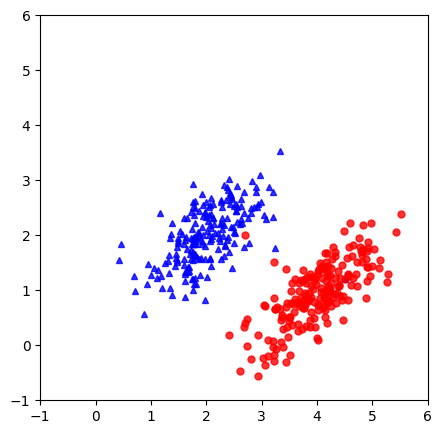

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

### Cách 1

In [7]:
!pip install cvxopt
from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
# K ~ P in lib cvxopt.qp
K = matrix(V.T.dot(V))

q = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, q, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[5.25267195e-07 1.57748499e-06 4.69843968e-06 5.56792106e-07
  5.33000280e-07 2.88641376e-07 8.73793643e-07 6.74020603e-07
  4.43968824e-07 4.51414944e-07 8.86510699e-07 1.72917984e-05
  4.15452625e-07 3.57064005e-07 3.61661308e-07 3.29989042e-07
  2.50020772e-06 3.10280732e-07 3.36170260e-07 4.52489584e-07
  4.54336470e-07 2.55092033e-07 7.41438160e-07 1.00984252e-06
  1.92237380e-06 3.56977688e-07 3.95459162e-07 3.43385045e-07
  2.97403461e-07 2.67640540e-07 3.67642812e-07 6.08650396e-07
  3.26464914e-07 5.14914858e-07 4.15888556e-07 4.29866763e-07
  1.55726161e-06 2.10773384e-07 2.30625577e-07 7.05440996e-07
  1.44204838e-06 3.62781577e-07 3.83097667e-07 3.82321515e-07
  1.09905156e-06 1.20196728e-06 2.51771682e-07 4.22330705e-07
  2.12112030e-07 7.72276924e-07 8.68053231e-07 3.83035216e-07
  3.81929311e-07 3.49062560e-07 8.21674527e-07 4.08058914e-07
  9.19245610e-07 1.02663224e-06 5.71226275e-07 9.46460681e-07
  3.07051543e-07 3.93734748e-07 7.22616848e-07 4.59469352e-

In [8]:
# 1. Đảm bảo y là mảng 1 chiều để tránh lỗi index
y = np.array(y).flatten() # Biến y thành shape (N,)
l = np.array(l).flatten() # Biến lambda thành shape (N,)

# 2. Tìm các tập chỉ số (Index sets)
S = np.where(l > 1e-5)[0]      # Support Vectors
S2 = np.where(l < 0.999*C)[0]  # Non-bound
M = np.intersect1d(S, S2)      # Intersection (nằm trên margin)

# 3. Lấy dữ liệu
# X giữ nguyên shape (2, N)
XS = X[:, S]
yS = y[S]   # Bây giờ truy cập y[S] là an toàn vì y đã là 1D
lS = l[S]

# 4. Tính w_dual
# Reshape yS và lS thành (k, 1) để nhân đúng chiều ma trận
# w = sum(lambda_i * y_i * x_i)
w_dual = XS.dot((lS * yS).reshape(-1, 1))

# 5. Tính b_dual
XM = X[:, M]
yM = y[M]
# b = mean(y_k - w^T * x_k)
# w_dual.T.dot(XM) sẽ ra (1, len(M)), yM là (len(M),)
# Ta reshape yM thành (1, len(M)) để trừ khớp chiều
b_dual = np.mean(yM.reshape(1, -1) - w_dual.T.dot(XM))

print('w = \n', w_dual)
print('b = ', b_dual)

w = 
 [[-1.40914018]
 [ 1.4820262 ]]
b =  2.158356055643387


### Cách 2

In [9]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data
Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C
def cost(w):
  u = w.T.dot(Z) # as in (23)
  return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias
def grad(w):
  u = w.T.dot(Z) # as in (23)
  H = np.where(u < 1)[1]
  ZS = Z[:, H]
  g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
  g[-1] -= lam*w[-1] # no weight decay on bias
  return g
eps = 1e-6

In [10]:
def grad_descent(w0, eta):
  w = w0
  it = 0
  while it < 100000:
    it = it + 1
    g = grad(w)
    w -= eta*g
    if (it % 10000) == 1:
      print('iter %d' %it + ' cost: %f' %cost(w))
    if np.linalg.norm(g) < 1e-5:
      break
  return w

In [11]:
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 258.076908


C:\Users\DELL\AppData\Local\Temp\ipykernel_12568\2172632942.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 10001 cost: 8.468796
iter 20001 cost: 8.470570
iter 30001 cost: 8.482792
iter 40001 cost: 8.483984
iter 50001 cost: 8.469646
iter 60001 cost: 8.483612
iter 70001 cost: 8.470070
iter 80001 cost: 8.468793
iter 90001 cost: 8.470496
[[-1.41285373  1.49077867]] [2.15927304]


### Cách 3

In [12]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-1.40954464  1.48259076]]
b =  [2.1611109]


## Bài tập thực hành 1

### 1. Độ chính xác Accuracy và ma trận nhầm lẫn Confusion Matrix

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
decision_values = np.dot(w_dual.T, X) + b_dual
y_pred = np.sign(decision_values).flatten()
y_pred[y_pred == 0] = 1
y_true = np.array(y).flatten()
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
print(f"Accuracy Score: {acc * 100:.2f}%")
print("-" * 30)
print("Confusion Matrix (Labels: [1, -1]):")
print(cm)

Accuracy Score: 99.50%
------------------------------
Confusion Matrix (Labels: [1, -1]):
[[199   1]
 [  1 199]]


### 2. Thay đổi giá trị hằng số, đưa ra độ chính xác:

In [14]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score, confusion_matrix

def train_svm(C, X, y):
    """
    Hàm huấn luyện SVM sử dụng CVXOPT để giải bài toán Dual.
    Input:
        C: Hằng số Regularization (float)
        X: Dữ liệu đầu vào, shape (2, N_samples)
        y: Nhãn lớp, shape (1, N_samples) hoặc (N_samples,)
    Output:
        w: Vector trọng số
        b: Bias
        l: Vector lambda (Lagrange multipliers)
    """
    # 1. Xử lý dữ liệu đầu vào cho chuẩn chiều
    y = np.array(y).flatten()  # Đưa về mảng 1 chiều (N,)
    n_samples = X.shape[1]     # Số lượng điểm dữ liệu

    # 2. Xây dựng ma trận V (thay vì dùng X0, X1, ta dùng X và y trực tiếp)
    # V = [y_1*x_1, y_2*x_2, ...]
    V = X * y.reshape(1, -1)

    # 3. Tạo các ma trận cho thư viện cvxopt
    # K = V.T * V
    K = matrix(V.T.dot(V))

    # q = [-1, -1, ...]
    q = matrix(-np.ones((n_samples, 1)))

    # G mở rộng: phần trên là -I (cho lambda >= 0), phần dưới là I (cho lambda <= C)
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))

    # h mở rộng: phần trên là 0, phần dưới là C
    h = matrix(np.vstack((np.zeros((n_samples, 1)), C * np.ones((n_samples, 1)))))

    # A = y^T, b = 0 (ràng buộc đẳng thức: sum(lambda_i * y_i) = 0)
    A = matrix(y.reshape((1, -1)).astype(np.double))
    b = matrix(np.zeros((1, 1)))

    # 4. Giải bài toán quy hoạch toàn phương (QP)
    solvers.options['show_progress'] = False
    sol = solvers.qp(K, q, G, h, A, b)

    l = np.array(sol['x']).flatten() # Lấy lambda ra

    # 5. Tìm tập Support Vectors (S) và Margin (M)
    epsilon = 1e-5
    S = np.where(l > epsilon)[0]                 # Tập Support Vectors (lambda > 0)
    S2 = np.where(l < C - epsilon)[0]            # Tập chưa chạm trần C
    M = np.intersect1d(S, S2)                    # Tập nằm trên Margin (0 < lambda < C)

    # 6. Tính w và b
    XS = X[:, S]
    yS = y[S]
    lS = l[S]

    # Tính w = sum(lambda * y * x)
    w_dual = XS.dot((lS * yS).reshape(-1, 1))

    # Tính b dựa trên tập M
    if len(M) > 0:
        XM = X[:, M]
        yM = y[M]
        # b = mean(y - w.T * x)
        b_dual = np.mean(yM.reshape(1, -1) - w_dual.T.dot(XM))
    else:
        # Nếu không có điểm nào nằm hẳn trên margin (trường hợp hiếm), dùng tạm S
        b_dual = np.mean(yS.reshape(1, -1) - w_dual.T.dot(XS))

    return w_dual, b_dual

# --- Hàm phụ trợ để dự đoán và in kết quả ---
def predict_and_evaluate(w, b, X, y):
    y = np.array(y).flatten()
    # Dự đoán: y_pred = sign(w.T * X + b)
    y_pred = np.sign(np.dot(w.T, X) + b).flatten()
    # Xử lý trường hợp = 0 thì gán là 1
    y_pred[y_pred == 0] = 1

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=[1, -1])
    return acc, cm

In [15]:
C_values = [1000, 200, 10, 0.5]

print(f"{'C':<10} | {'Accuracy':<10} | {'Confusion Matrix (Lớp 1, -1)':<30}")
print("-" * 60)

for C_val in C_values:
    # 1. Huấn luyện
    w, b = train_svm(C_val, X, y)

    # 2. Đánh giá
    acc, cm = predict_and_evaluate(w, b, X, y)

    # In kết quả gọn gàng
    cm_str = str(cm.tolist()) # Chuyển CM thành chuỗi để in 1 dòng
    print(f"{C_val:<10} | {acc*100:.2f}%     | {cm_str:<30}")

C          | Accuracy   | Confusion Matrix (Lớp 1, -1)  
------------------------------------------------------------
1000       | 99.50%     | [[199, 1], [1, 199]]          
200        | 99.50%     | [[199, 1], [1, 199]]          
10         | 99.50%     | [[199, 1], [1, 199]]          
0.5        | 99.50%     | [[199, 1], [1, 199]]          


## Bài tập thực hành 2

In [16]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
cancer_data = datasets.load_breast_cancer()
X = cancer_data.data
y = cancer_data.target
y_svm = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_svm, test_size=0.3, random_state=109
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_T = X_train_scaled.T
X_test_T = X_test_scaled.T

In [17]:
w_trained, b_trained = train_svm(C=10, X=X_train_T, y=y_train)

In [18]:
y_pred = np.sign(np.dot(w_trained.T, X_test_T) + b_trained).flatten()
y_pred[y_pred == 0] = 1
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])

print("\n" + "="*30)
print(f"Kết quả trên tập Test (Breast Cancer):")
print(f"Accuracy: {acc * 100:.2f}%")
print("Confusion Matrix (Lớp 1: Lành tính, Lớp -1: Ác tính):")
print(cm)
print("="*30)


Kết quả trên tập Test (Breast Cancer):
Accuracy: 99.42%
Confusion Matrix (Lớp 1: Lành tính, Lớp -1: Ác tính):
[[108   0]
 [  1  62]]


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
print("Đang tải dữ liệu...")
df = pd.read_csv(url, header=None)
X = df.iloc[:, :-1].values  # 60 cột đầu
y_str = df.iloc[:, -1].values # Cột cuối cùng (R/M)
y = np.where(y_str == 'M', 1, -1)
print(f"Kích thước dữ liệu: {X.shape}")
print(f"Số lượng lớp Mine (1): {np.sum(y==1)}")
print(f"Số lượng lớp Rock (-1): {np.sum(y==-1)}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_T = X_train_scaled.T
X_test_T = X_test_scaled.T

Đang tải dữ liệu...
Kích thước dữ liệu: (208, 60)
Số lượng lớp Mine (1): 111
Số lượng lớp Rock (-1): 97


In [40]:
C_random = np.random.uniform(1, 100)
w, b = train_svm(C_random, X_train_T, y_train)
acc, cm = predict_and_evaluate(w, b, X_test_T, y_test)
print(f"|C =  {C_random:<12.4f} | accuracy =  {acc*100:.2f}%     | cm = {str(cm.tolist())}")

|C =  61.6767      | accuracy =  83.33%     | cm = [[21, 5], [2, 14]]


## Ví dụ 3 Lọc thư rác

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [42]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
print("Đang tải dữ liệu Spambase (có thể mất vài giây)...")
df = pd.read_csv(url, header=None)
X = df.iloc[:, :-1].values  # 57 cột đầu
y_orig = df.iloc[:, -1].values # Cột cuối
y = np.where(y_orig == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_T = X_train_scaled.T
X_test_T = X_test_scaled.T

Đang tải dữ liệu Spambase (có thể mất vài giây)...


In [43]:
C_random = np.random.uniform(1, 100)
w, b = train_svm(C_random, X_train_T, y_train)
acc, cm = predict_and_evaluate(w, b, X_test_T, y_test)
cm_flat = cm.flatten().tolist()
print(f"| C = {C_random:<12.4f} | Accuracy = {acc*100:.2f}%     |CM = {str(cm.tolist())}")

KeyboardInterrupt: 